#### **Inflation Forecasting**

**Author: Fabián Villarreal Sosa**

Notebook to compare between machine learning models and classic econometric models to forecast inflation in Ecuador.

References: 
* Araujo, G. S., & Gaglianone, W. P. (2020). Machine learning methods for inflation forecasting in Brazil: New contenders versus classical models. *CEMLA*.
[Link](https://www.cemla.org/actividades/2020-final/2020-10-xxv-meeting-cbrn/Session%202/3.%20Machine_Learning...%20Wagner%20Piazza.pdf)

In [223]:
# Librerias
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import mplcursors
import seaborn as sns

import datetime as dt

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)
import statsmodels.formula.api as sm

from xgboost import XGBRegressor, plot_importance

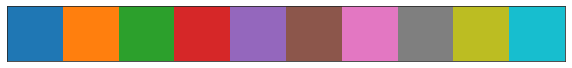

In [224]:
# Graphics style
sns.set_style('white')
csfont = {'fontname':'Calibri'}

# Color palette
my_palette = ['#4472C4', '#ED7D31', '#A5A5A5', '#FFC000', '#5B9BD5', '#70AD47', '#264478', '#9E480E', '#636363', '#997300'] # Excel color palette
my_palette2 = sns.color_palette('tab10')
sns.palplot(sns.color_palette('tab10'))

# Define palette
sns.set_palette(my_palette2)

In [225]:
# Change directory
os.chdir('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Data')
os.getcwd()

'C:\\Users\\fvill\\Dropbox\\DS_ML_Projects\\Inflation_Forecasting\\Data'

In [226]:
# Data
df = pd.read_csv('final_dataframe_ipc.csv')

print(df.shape)
df.head()

(213, 50)


,date,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,...,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,pos_sucre,res_internacional,ipp,ipcons
0,2004-01-01,65.95,102.870594,103.509825,96.533766,106.319005,101.967123,77.748841,74.175894,2648.634643,...,4.150500,868.32,337.70,10.43,25.41,-1.44,NaN,1240.42,61.89,141.53
1,2004-02-01,66.40,106.416805,104.178680,97.211906,107.276700,103.401263,78.399193,70.401638,2674.554642,...,4.084211,844.86,334.41,2.93,25.39,-1.02,NaN,1206.57,63.92,144.85
2,2004-03-01,66.87,107.844485,105.793566,97.579271,106.919136,104.142381,78.893621,82.953463,2560.377642,...,3.826522,752.60,357.93,47.35,25.39,-1.65,NaN,1181.62,65.59,149.13
3,2004-04-01,67.30,108.420300,105.424685,97.296079,107.215493,104.176860,79.220693,79.764433,2574.293642,...,4.347619,867.16,328.21,17.29,24.90,-1.50,NaN,1236.06,65.24,152.82
4,2004-05-01,66.98,106.551494,105.378734,97.854182,107.619727,103.982039,79.412239,76.053673,2665.753688,...,4.715500,866.90,332.21,10.23,25.19,-1.55,NaN,1232.98,64.59,157.37


##### **Cleaning and data mining**

* The cleaning and data mining process was carried out in the 'Datos.ipynb' script.

In [227]:
df['date'] = pd.to_datetime(df['date'])

In [228]:
# Missing values
cols_nans = df.columns[df.isna().any()]
cols_nans

Index(['din_elec', 'pos_sucre'], dtype='object')

In [229]:
# Remove variables with missing values
df.drop(cols_nans, axis = 1, inplace = True)

##### **Data exploration**

* We explore the behavior of the CPI along with other variables and their correlation.

In [230]:
df.describe()

,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,caja_bce,...,CPI_US,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,res_internacional,ipp,ipcons
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,...,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,90.573146,193.121124,138.374738,111.247542,138.225293,140.837605,132.156037,131.998480,12182.943293,424.916925,...,228.406892,2.868580,2702.862160,873.301596,23.023521,34.552958,1.674366,3666.575915,90.606761,220.572207
std,14.291268,39.593242,13.498283,6.453254,11.458776,15.540000,29.868151,31.084250,8092.539372,223.475144,...,21.720889,1.138089,1149.419615,418.989087,65.374594,7.583121,8.880850,1295.992576,13.521277,28.285939
min,65.950000,102.870594,103.509825,96.533766,106.319005,101.967123,77.748841,70.401638,2560.377642,57.840000,...,186.300000,0.623636,469.200000,328.210000,0.140000,24.430000,-26.680000,1181.620000,61.890000,141.530000
25%,78.600000,168.730776,130.201817,106.626623,133.742724,132.520250,101.110747,101.926132,4562.729915,220.795579,...,212.705000,1.978095,1852.230000,494.930000,8.380000,26.260000,-0.430000,2790.040000,81.990000,211.090000
50%,94.580000,213.391527,144.580523,113.170036,143.549848,148.878440,147.626107,142.950634,9574.567546,440.924196,...,231.249000,2.698636,2619.690000,793.200000,23.660000,39.170000,0.040000,3668.880000,96.020000,235.040000
75%,104.970000,225.428375,148.892973,116.090462,146.544474,152.828103,157.251953,157.139249,20640.197470,570.522437,...,244.006000,3.814091,3237.410000,1137.640000,25.290000,40.480000,3.240000,4274.630000,102.190000,238.620000
max,106.560000,233.698072,154.318022,120.993600,150.434876,157.286879,168.943404,182.962177,28797.135580,1108.461104,...,274.214000,5.110000,6065.240000,1960.070000,960.530000,45.240000,55.930000,7195.650000,104.800000,267.670000


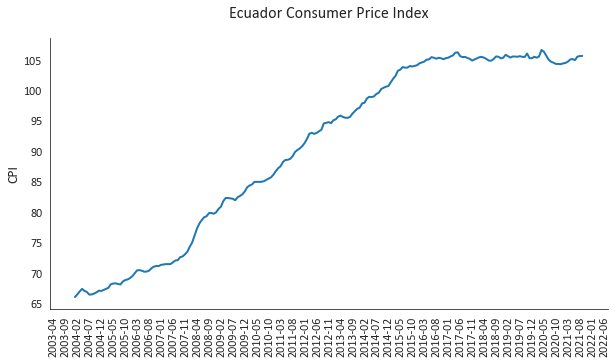

In [231]:
# Graph: IPC
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = 'ipc',
              linewidth = 2,
              color = my_palette2[0],
              ax = ax)
plt.title('Ecuador Consumer Price Index', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

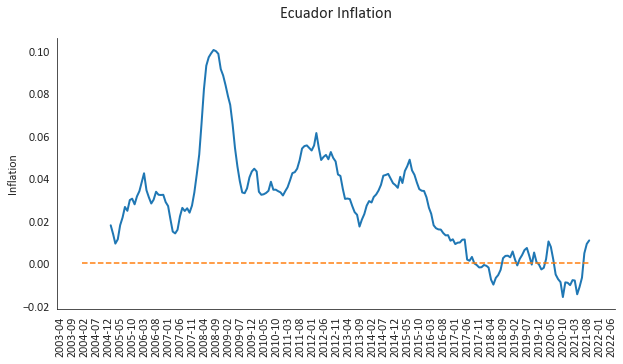

In [232]:
# Graph: Inflation
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = df['ipc'].pct_change(periods = 12), # Ecuador interannual inflation
              linewidth = 2,
              color = my_palette2[0],
              ax = ax)
sns.lineplot(data = df, x = 'date', y = 0, color = my_palette2[1], linestyle = '--')
plt.title('Ecuador Inflation', fontsize = 16, pad = 20, **csfont)
plt.ylabel('Inflation', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

sns.despine()
plt.gcf().set_size_inches(10, 5);

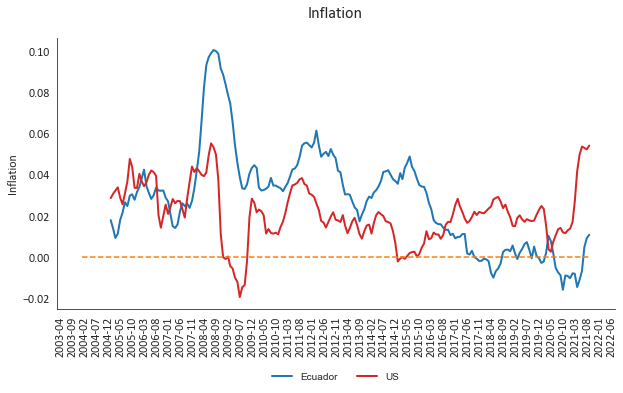

In [233]:
# Graph: Inflation (Ecuador vs US)
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = df['ipc'].pct_change(periods = 12), # Ecuador interannual inflation
              linewidth = 2,
              color = my_palette2[0],
              label = 'Ecuador',
              ax = ax)
sns.lineplot(data = df,
              x = 'date',
              y = df['CPI_US'].pct_change(periods = 12), # US interannual inflation
              linewidth = 2,
              color = my_palette2[3],
              label = 'US',
              ax = ax)
sns.lineplot(data = df, x = 'date', y = 0, color = my_palette2[1], linestyle = '--')
plt.title('Inflation', fontsize = 16, pad = 20, **csfont)
plt.ylabel('Inflation', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

sns.despine()
plt.gcf().set_size_inches(10, 5);

In [234]:
# Correlation matrix
num_cols = df.drop(['date'], axis = 1).columns
df[num_cols].corr().head()

,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,caja_bce,...,CPI_US,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,res_internacional,ipp,ipcons
ipc,1.000000,0.931881,0.906384,0.823421,0.846815,0.902907,0.954765,0.916484,0.902956,0.706139,...,0.951851,-0.863967,0.358788,0.437306,0.080685,0.861823,-0.181672,0.480010,0.979800,0.924084
ind_man,0.931881,1.000000,0.990449,0.941728,0.968617,0.994696,0.975246,0.945258,0.737803,0.768525,...,0.883488,-0.803591,0.446005,0.535261,0.100180,0.854029,-0.093874,0.597440,0.969198,0.959074
ind_com,0.906384,0.990449,1.000000,0.948346,0.978729,0.995589,0.954859,0.927928,0.712581,0.751213,...,0.868670,-0.768025,0.468716,0.522636,0.106233,0.817443,-0.069837,0.612732,0.948806,0.952131
ind_con,0.823421,0.941728,0.948346,1.000000,0.931697,0.961438,0.901619,0.880248,0.557359,0.718162,...,0.731207,-0.681585,0.491485,0.379980,0.112721,0.803066,-0.062427,0.595684,0.875490,0.879912
ind_ser,0.846815,0.968617,0.978729,0.931697,1.000000,0.984252,0.904280,0.877928,0.626877,0.735449,...,0.819815,-0.732520,0.485287,0.569654,0.108257,0.749825,-0.008948,0.642339,0.913933,0.948616


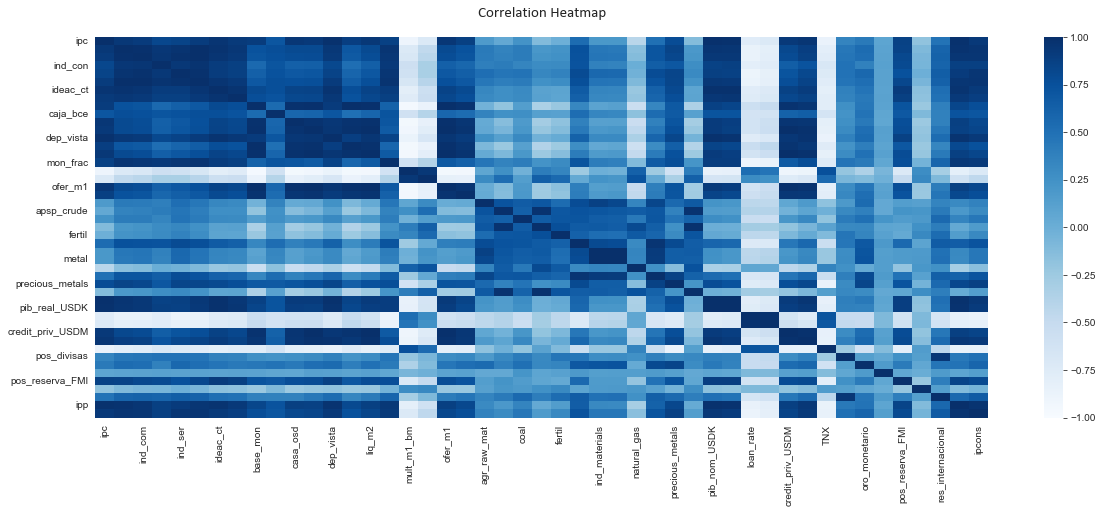

In [235]:
# Heatmap: Correlation matrix
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.heatmap(df[num_cols].corr(),
            vmin = -1, vmax = 1,
            cmap = 'Blues')
plt.title('Correlation Heatmap', fontsize = 15, pad = 20, **csfont)
plt.gcf().set_size_inches(20, 7);

In [236]:
# Define function for scatter plots
def scatter_plot(data, x_var, y_var, color, title, x_label, y_label):
  
  fig, ax = plt.subplots(nrows = 1, ncols = 1)
  sns.scatterplot(data = data,
                  x = x_var,
                  y = y_var,
                  alpha = 0.4,
                  color = color)
  plt.title(f'{title}', fontsize = 16, pad = 20, **csfont)
  plt.xlabel(f'{x_label}', fontsize = 12, labelpad = 15, **csfont)
  plt.xticks(fontsize = 12, rotation = 90, **csfont)
  plt.ylabel(f'{y_label}', fontsize = 12, **csfont)
  plt.yticks(fontsize = 12, **csfont)

  sns.despine()
  plt.gcf().set_size_inches(10, 5);


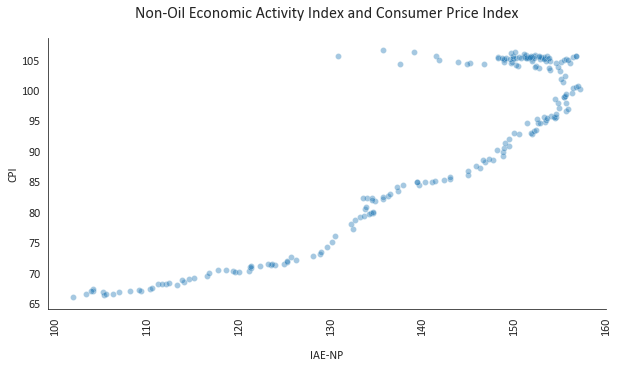

In [237]:
scatter_plot(df, 'iae_np', 'ipc', my_palette2[0], 
            'Non-Oil Economic Activity Index and Consumer Price Index', 
            'IAE-NP', 
            'CPI')

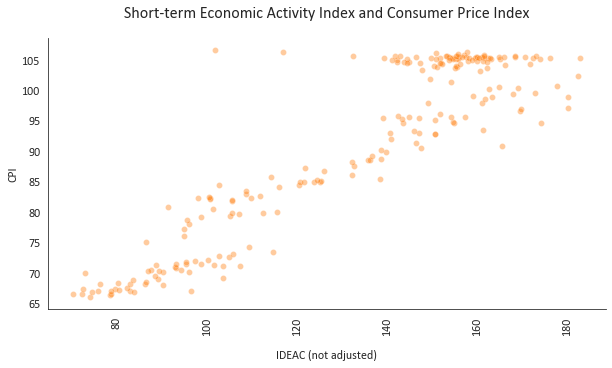

In [238]:
scatter_plot(df, 'ideac_sb', 'ipc', my_palette2[1], 
            'Short-term Economic Activity Index and Consumer Price Index', 
            'IDEAC (not adjusted)', 
            'CPI')

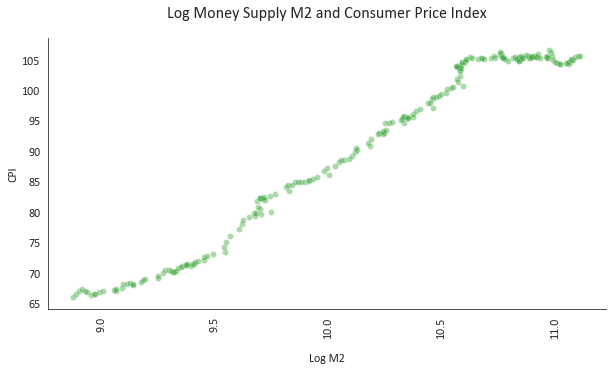

In [239]:
scatter_plot(df, np.log(df['liq_m2']), 'ipc', my_palette2[2], 
            'Log Money Supply M2 and Consumer Price Index', 
            'Log M2', 
            'CPI')

##### **Time Series treatment**

**Unit Root Test**

* When dealing with time series data, prior to the estimation of the models, we tested for the existence of unit root. The presence of unit root can generate problems of spurious correlation, which means that the estimation determines coefficients that express a false relationship between variables.

* We need to make our time-series stationary: stationary means that the statistical properties like mean, variance, and autocorrelation of your dataset stay the same over time. If the series is not stationary, a difference is applied.

* We use the Augmented Dickey-Fuller Test.

In [240]:
# Unit Root Test: Augmented Dickey-Fuller unit root test
# H0: there is a unit root

from statsmodels.tsa.stattools import adfuller;

In [241]:
# Dataframe that will contain the stationary series
df_stat = df[['date']].copy()

# Function to create stationary variables
def gen_stationary(var):
  if adfuller(df[var], autolag = 'AIC')[1] > 0.05: # If H0 is not rejected at the 95% confidence level
    df_stat[var + '_diff'] = df[var].diff()
  else:
    df_stat[var] = df[var]

In [242]:
# Evaluate each variable in the dataframe
for var in df.drop(['date'], axis = 1).columns:
  gen_stationary(var);

In [243]:
# Remove missing values in Ecuador CPI variable
df_stat = df_stat[df_stat['ipc_diff'].notna()]

df_stat.head()

,date,ipc_diff,ind_man_diff,ind_com_diff,ind_con_diff,ind_ser,iae_np_diff,ideac_ct_diff,ideac_sb_diff,base_mon_diff,...,CPI_US_diff,TNX_diff,pos_divisas,oro_monetario_diff,DEGs_diff,pos_reserva_FMI_diff,pos_ALADI_diff,res_internacional,ipp_diff,ipcons_diff
1,2004-02-01,0.45,3.546210,0.668855,0.678140,107.276700,1.434140,0.650352,-3.774256,25.919999,...,0.4,-0.066289,844.86,-3.29,-7.50,-0.02,0.42,1206.57,2.03,3.32
2,2004-03-01,0.47,1.427681,1.614885,0.367364,106.919136,0.741118,0.494428,12.551825,-114.177000,...,0.4,-0.257689,752.60,23.52,44.42,0.00,-0.63,1181.62,1.67,4.28
3,2004-04-01,0.43,0.575815,-0.368881,-0.283192,107.215493,0.034479,0.327072,-3.189030,13.916000,...,0.3,0.521097,867.16,-29.72,-30.06,-0.49,0.15,1236.06,-0.35,3.69
4,2004-05-01,-0.32,-1.868806,-0.045951,0.558103,107.619727,-0.194820,0.191546,-3.710760,91.460046,...,0.8,0.367881,866.90,4.00,-7.06,0.29,-0.05,1232.98,-0.65,4.55
5,2004-06-01,-0.20,1.701484,1.395899,1.635849,107.791548,1.260982,0.094894,-1.325310,45.623234,...,0.7,0.018310,849.38,2.16,-0.01,-0.02,-0.77,1216.81,-0.41,1.43


In [244]:
# Correlation matrix
num_cols = df_stat.drop(['date'], axis = 1).columns
df_stat[num_cols].corr().head()

,ipc_diff,ind_man_diff,ind_com_diff,ind_con_diff,ind_ser,iae_np_diff,ideac_ct_diff,ideac_sb_diff,base_mon_diff,caja_bce_diff,...,CPI_US_diff,TNX_diff,pos_divisas,oro_monetario_diff,DEGs_diff,pos_reserva_FMI_diff,pos_ALADI_diff,res_internacional,ipp_diff,ipcons_diff
ipc_diff,1.000000,0.009423,0.009845,0.000277,0.004398,0.010990,0.052844,-0.221017,-0.075886,0.048022,...,-0.006946,-0.033203,0.133017,0.113654,0.021946,0.039248,0.029572,0.113376,0.103436,0.315791
ind_man_diff,0.009423,1.000000,0.874425,0.784192,-0.032491,0.935315,0.265284,-0.006453,-0.089855,0.078593,...,0.102056,0.182046,0.026904,0.219601,0.008481,0.009337,-0.031756,0.058812,0.006698,0.100767
ind_com_diff,0.009845,0.874425,1.000000,0.848844,-0.003429,0.957355,0.160043,-0.061633,-0.152048,0.122957,...,0.025434,0.108565,0.004537,0.149926,-0.009712,-0.052434,-0.039135,0.022926,-0.046281,0.072240
ind_con_diff,0.000277,0.784192,0.848844,1.000000,0.034856,0.923613,0.142563,-0.074045,-0.177942,0.139201,...,0.071947,0.166135,0.046100,0.138719,0.010519,0.017680,-0.031608,0.075544,0.016668,0.126709
ind_ser,0.004398,-0.032491,-0.003429,0.034856,1.000000,-0.011932,-0.012997,-0.003171,0.062536,0.001425,...,-0.024030,-0.021134,0.475878,-0.038706,-0.002673,0.015870,-0.016128,0.634597,-0.052128,-0.188858


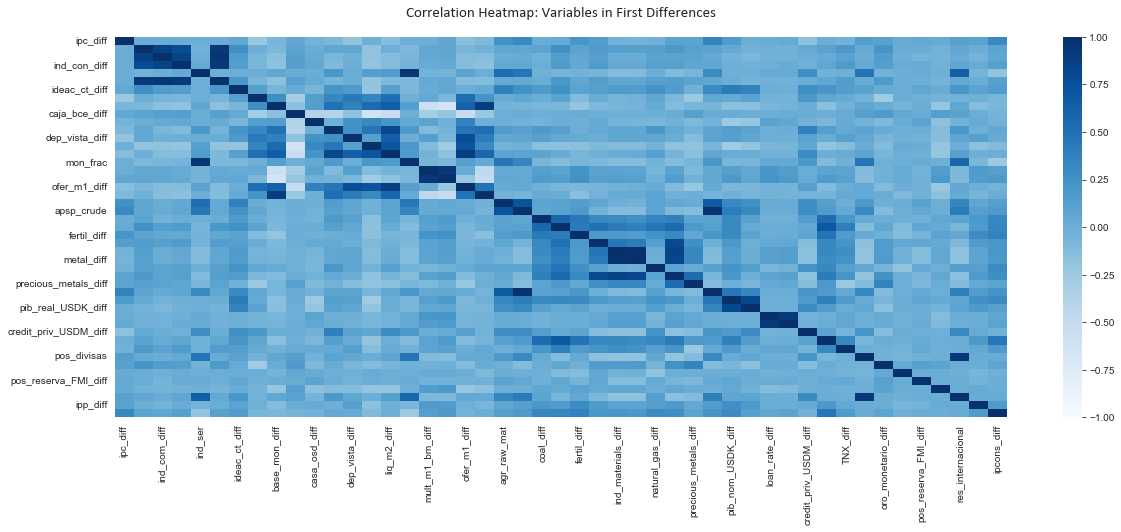

In [245]:
# Heatmap: Correlation matrix in first differences
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.heatmap(df_stat[num_cols].corr(),
            vmin = -1, vmax = 1,
            cmap = 'Blues')
plt.title('Correlation Heatmap: Variables in First Differences', fontsize = 15, pad = 20, **csfont)
plt.gcf().set_size_inches(20, 7);

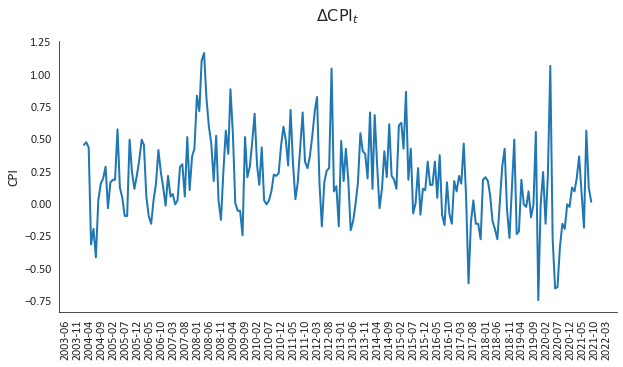

In [246]:
# Graph: CPI
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df_stat, x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette2[0], ax = ax)

plt.title('$\Delta\mathrm{CPI}_{t}$', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

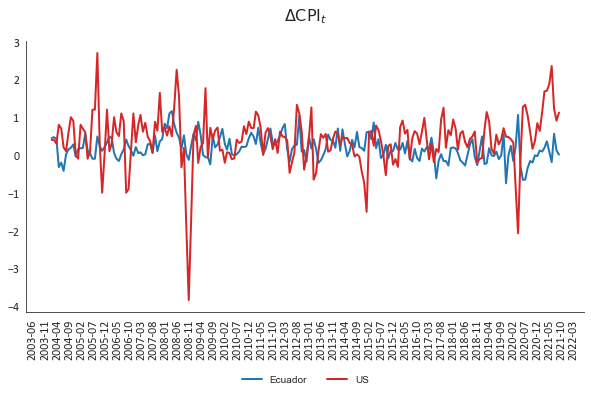

In [247]:
# Graph: CPI (Ecuador vs US)
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df_stat, x = 'date', y = 'ipc_diff', linewidth = 2, color = my_palette2[0], label = 'Ecuador', ax = ax)
sns.lineplot(data = df_stat, x = 'date', y = 'CPI_US_diff', linewidth = 2, color = my_palette2[3], label = 'US', ax = ax)

plt.title('$\Delta\mathrm{CPI}_{t}$', fontsize = 16, pad = 20, **csfont)
plt.ylabel('', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

##### **Training and Testing Datasets**

* Split the dataset to create a training and a testing dataset (proportion of 75 to 25).

Stationary and level datasets

In [248]:
print(df_stat.shape[0] * 0.75) # 75% of the data

159.0


In [249]:
df_stat.sort_values(['date'], inplace = True)
df_stat.loc[159, 'date']

Timestamp('2017-04-01 00:00:00')

In [250]:
# Testing and Training Datasets
f1 = df_stat['date'] <= '2017-04-01' 
f2 = df_stat['date'] > '2017-04-01'

df_stat_train = df_stat.loc[f1, :]
df_stat_test = df_stat.loc[f2, :]

In [251]:
# Testing and Training Datasets
f1 = df['date'] <= '2017-04-01' 
f2 = df['date'] > '2017-04-01'

df_train = df.loc[f1, :]
df_test = df.loc[f2, :]

##### **ARIMA Forecasting Model**

First, an exercise is carried out to estimate the behavior of inflation, through the CPI, using an ARIMA model, which consists of a univariate time series model.

To estimate the orders of an ARIMA model $\left( p,d,q \right)$, we use the Hyndman-Khandakar algorithm ([Link](https://www.jstatsoft.org/article/view/v027i03)), which combines unit root tests, minimisation of the AICc and MLE to obtain an ARIMA model.

* ACF and PACF graphs to determine the orders of q and p.

In [252]:
import statsmodels.api as sm

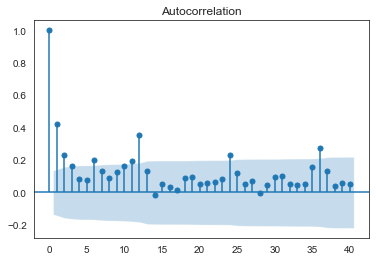

In [253]:
# Autocorrelation function
sm.graphics.tsa.plot_acf(df_stat['ipc_diff'], lags = 40);

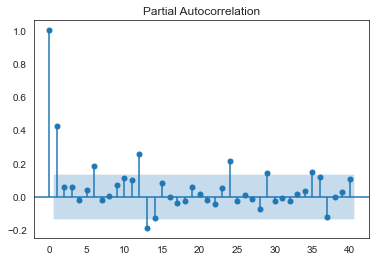

In [254]:
# Partial autocorrelation function
sm.graphics.tsa.plot_pacf(df_stat['ipc_diff'], lags = 40);

In [255]:
# Reference: https://brittarude.github.io/blog/2020/11/22/britta-rude-forecasting-with-python
# pip install pmdarima

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

cpi_arima1 = pm.auto_arima(df['ipc'],
                           seasonal = False, d = 1)

cpi_arima2 = pm.auto_arima(df['ipc'],
                           seasonal = False, d = 1,
                           approximation = False, stepwise = False)

cpi_arima3 = pm.auto_arima(df['ipc'],
                           seasonal = True, d = 1)

cpi_arima4 = pm.auto_arima(df['ipc'],
                           seasonal = True, d = 1,
                           approximation = False, stepwise = False)

In [256]:
# Vector with the AICs of the models
arima_aic = []
arima_aic.append(cpi_arima1.aic())
arima_aic.append(cpi_arima2.aic())
arima_aic.append(cpi_arima3.aic())
arima_aic.append(cpi_arima4.aic())

In [257]:
# Model with the lowest AIC
print(np.argmin(arima_aic) + 1)

1


In [258]:
# Summary
cpi_arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  213
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 -31.773
Date:                Sun, 06 Mar 2022   AIC                             71.545
Time:                        20:10:18   BIC                             84.972
Sample:                             0   HQIC                            76.972
                                - 213                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3261      0.059     22.488      0.000       1.210       1.442
ar.L2         -0.3298      0.058     -5.695      0.000      -0.443      -0.216
ma.L1         -0.9494      0.031    -30.707      0.000      -1.010      -0.889
sigma2         0.0786      0.006     12.154      0.000       0.066       0.091
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.36
Prob(Q):                              0.98   Prob(JB):                         0.04
Heteroskedasticity (H):               1.30   Skew:                             0.09
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Check the robustness of our model

In [259]:
# Ljung-Box test of autocorrelation in residuals
sm.stats.acorr_ljungbox(cpi_arima1.resid(), lags = 10, return_df = True)

,lb_stat,lb_pvalue
1,0.009582,0.922020
2,0.011825,0.994105
3,0.012820,0.999615
4,0.033227,0.999864
5,0.035447,0.999988
6,0.043518,0.999998
7,0.044217,1.000000
8,0.044530,1.000000
9,0.044842,1.000000
10,0.046084,1.000000


Residuals are stationary

C:\Users\fvill\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


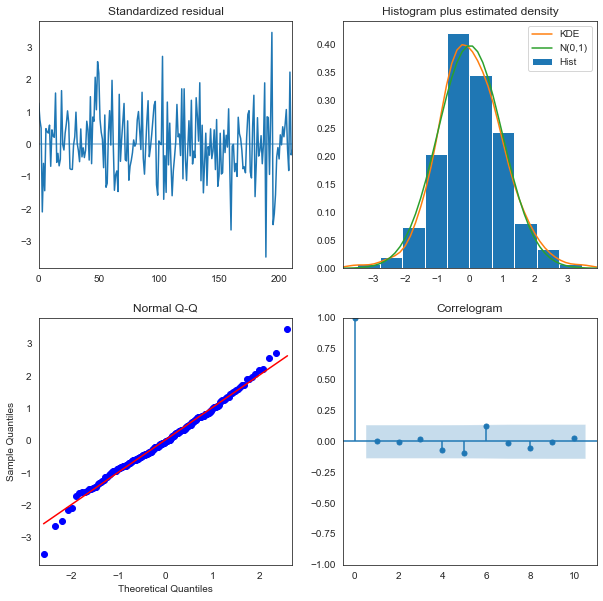

In [260]:
cpi_arima1.plot_diagnostics(figsize = (10, 10))
plt.show();

In [261]:
# Model estimation between training and testing datasets
# Reference: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMAResults.get_forecast.html#statsmodels.tsa.arima.model.ARIMAResults.get_forecast

cpi_arima = sm.tsa.arima.ARIMA(df_train['ipc'].values, order = (2, 1, 1))
cpi_arima_fit = cpi_arima.fit()
cpi_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  160
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -17.613
Date:                Sun, 06 Mar 2022   AIC                             43.227
Time:                        20:10:19   BIC                             55.502
Sample:                             0   HQIC                            48.212
                                - 160                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5201      0.395      1.318      0.188      -0.254       1.294
ar.L2          0.2384      0.276      0.865      0.387      -0.302       0.778
ma.L1          0.0036      0.410      0.009      0.993      -0.801       0.808
sigma2         0.0727      0.009      8.520      0.000       0.056       0.089
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.49   Prob(JB):                         0.75
Heteroskedasticity (H):               1.10   Skew:                             0.10
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [262]:
# Forecast
# https://stackoverflow.com/questions/66651360/arima-forecast-gives-different-results-with-new-python-statsmodels?rq=1

n_steps = len(df_test['ipc'])
cpi_forecast = cpi_arima_fit.get_forecast(steps = n_steps, dynamic = True)
cpi_forecast_ci = cpi_forecast.summary_frame(alpha = 0.05)

In [263]:
cpi_forecast_ci['date'] = pd.date_range(df_test['date'].min(), freq = 'M', periods = len(cpi_forecast_ci))
cpi_forecast_ci['date'] = cpi_forecast_ci['date'] - pd.offsets.MonthBegin(1)

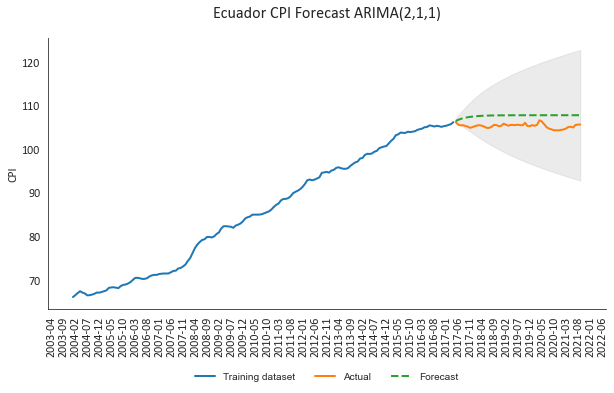

In [264]:
# Plot the CPI forecast from the ARIMA model
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.lineplot(data = df_train, x = 'date', y = 'ipc', linewidth = 2, color = my_palette2[0], label = 'Training dataset', ax = ax)
sns.lineplot(data = df_test, x = 'date', y = 'ipc', linewidth = 2, color = my_palette2[1], label = 'Actual', ax = ax)
sns.lineplot(data = cpi_forecast_ci, x = 'date', y = 'mean', linewidth = 2, color = my_palette2[2], label = 'Forecast', linestyle = '--', ax = ax)

plt.fill_between(cpi_forecast_ci['date'], cpi_forecast_ci['mean_ci_lower'], cpi_forecast_ci['mean_ci_upper'], color = my_palette2[7], alpha = 0.15)

plt.title('Ecuador CPI Forecast ARIMA(2,1,1)', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

In [265]:
# Prediction
start_p = len(df_train)
end_p = start_p + len(df_test)

cpi_predict = cpi_arima_fit.get_prediction(start = start_p, end = end_p, dynamic = True)
cpi_predict_ci = cpi_predict.summary_frame(alpha = 0.05)

In [266]:
cpi_predict_ci['date'] = pd.date_range(df_test['date'].min(), freq = 'M', periods = len(cpi_predict_ci))
cpi_predict_ci['date'] = cpi_predict_ci['date'] - pd.offsets.MonthBegin(1)

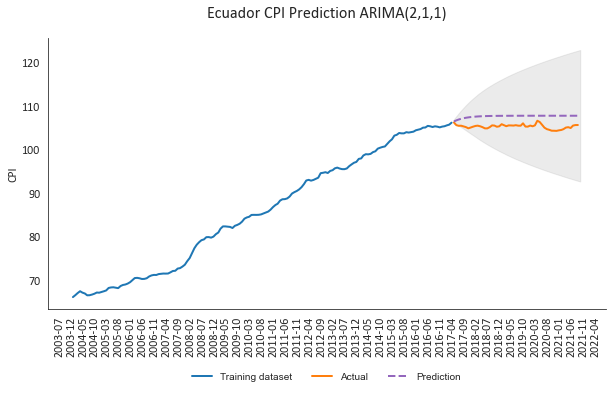

In [267]:
# Plot the CPI prediction from the ARIMA model
fig, ax = plt.subplots(nrows = 1, ncols = 1)

sns.lineplot(data = df_train, x = 'date', y = 'ipc', linewidth = 2, color = my_palette2[0], label = 'Training dataset', ax = ax)
sns.lineplot(data = df_test, x = 'date', y = 'ipc', linewidth = 2, color = my_palette2[1], label = 'Actual', ax = ax)
sns.lineplot(data = cpi_predict_ci, x = 'date', y = 'mean', linewidth = 2, color = my_palette2[4], label = 'Prediction', linestyle = '--', ax = ax)

plt.fill_between(cpi_predict_ci['date'], cpi_predict_ci['mean_ci_lower'], cpi_predict_ci['mean_ci_upper'], color = my_palette2[7], alpha = 0.15)

plt.title('Ecuador CPI Prediction ARIMA(2,1,1)', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);